# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

# base imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import datetime

# spark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, sum, avg, col, count, concat, desc, explode, lit, min, max, split, isnan, when, round
from pyspark.sql import Window
from pyspark.sql.types import IntegerType

# other imports
import httpagentparser # install required: pip install httpagentparser
from user_agents import parse # install required: pip install pyyaml ua-parser user-agents



In [2]:
# changed working directory

print(os.getcwd())
os.chdir('C:\\Users\\michael.a.hartmann\\Desktop\\sparkify')
print(os.getcwd())

C:\Users\michael.a.hartmann\Dropbox\Data Science Training\Working Directory
C:\Users\michael.a.hartmann\Desktop\sparkify


In [3]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

In [4]:
# check session details and access spark UI
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

---

<b>Load & Clean </b>

The orignial data set "mini_sparkify_event_data.json" consists of 18 columns

The mini data set has a file size of about 128MB. The original data set is about 12GB in size, so we are looking at a relatively small sample from the total records.

---

In [5]:
# load the dataset
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [6]:
# first we are looking at the quantities of the dataset
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))
text_columns = len([col for col in df.dtypes if col[1] == 'string'])
print("Text Columns:", text_columns)
print("Numberic Columns:", len(df.columns) - text_columns)

Number of rows: 286500
Number of columns: 18
Text Columns: 12
Numberic Columns: 6


In [7]:
# Let's have a look at the schema (columns of the dataset)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# look into a record
df.show(1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

In [9]:
# we can already see that some data wrangling will be necessary later, e.g. to convert the timestamp or userAgent field.

In [10]:
# next we have a look at the number of values per column
df.summary().show(1, vertical=True)

-RECORD 0---------------
 summary       | count  
 artist        | 228108 
 auth          | 286500 
 firstName     | 278154 
 gender        | 278154 
 itemInSession | 286500 
 lastName      | 278154 
 length        | 228108 
 level         | 286500 
 location      | 278154 
 method        | 286500 
 page          | 286500 
 registration  | 278154 
 sessionId     | 286500 
 song          | 228108 
 status        | 286500 
 ts            | 286500 
 userAgent     | 278154 
 userId        | 286500 
only showing top 1 row



In [11]:
# we can see there are values missing

In [12]:
# next we count missing values for each column
# we can do this with the filter function and isNull() | isnan by looping through the columns
# also we have to take empty strings '' into account

for col in df.columns:
    count_na = df.filter(isnan(df[col]) | df[col].isNull() | (df[col] == '')).count()
    print(col, count_na)

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 8346


In [13]:
# we can see that 8346 rows of user data are missing and 58392 data points related to songs (artist, song, length)
# lets investigate unique userIds

df.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [14]:
# we can see that there are empty userIds in the dataset.
df.where(df.userId == '').show(5)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [15]:
# it appears that the events where recoreded when the visitor was not logged into his account (auth='logged Out')
# without userId we cannot analyse the event for a partiular user. In this case we can filter out the missing values.

df_new = df.filter(df.userId != '')

# quick check on the cleaned data:

for col in df.columns:
    count_na = df_new.filter(isnan(df[col]) | df[col].isNull() | (df[col] == '')).count()
    print(col, count_na)

artist 50046
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 50046
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 50046
status 0
ts 0
userAgent 0
userId 0


In [16]:
# Alternative method to check for missing values in pyspark: 
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
# df_new.select([count(when(isnan(c) | c.isNull(), c)).alias(c) for c in df.columns]).show(vertical=True, truncate=False)

In [17]:
# convert the time columns from milliseconds into readable time format
# https://stackoverflow.com/questions/3682748/converting-unix-timestamp-string-to-readable-date

convert_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [18]:
# new column for 'registration'
df_new = df_new.withColumn('registration_time', convert_time('registration'))

In [19]:
# new column for 'ts'
df_new = df_new.withColumn('event_timestamp', convert_time('ts'))

In [20]:
df_new.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------
 artist            | Martha Tilston                                                           
 auth              | Logged In                                                                
 firstName         | Colin                                                                    
 gender            | M                                                                        
 itemInSession     | 50                                                                       
 lastName          | Freeman                                                                  
 length            | 277.89016                                                                
 level             | paid                                                                     
 location          | Bakersfield, CA                                                          
 method            | PUT                          

In [21]:
df_new.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', registration_time='2018-09-29 00:22:42', event_timestamp='2018-10-01 02:01:57')

In [22]:
# next we split the column 'location' into city and state
# https://stackoverflow.com/questions/39235704/split-spark-dataframe-string-column-into-multiple-columns

split_location = split(df_new['location'], ', ')
df_new = df_new.withColumn('city', split_location.getItem(0))
df_new = df_new.withColumn('state', split_location.getItem(1))

In [23]:
# last we parse the column 'userAgent' to get the browser and operating system that was used per event
# https://stackoverflow.com/questions/9209377/how-to-parse-user-agent-string-python

parse_browser = udf(lambda x: httpagentparser.detect(x)['browser']['name'])
parse_os = udf(lambda x: httpagentparser.detect(x)['os']['name'])


# edit: found a second parser that can detect the devices used and wether it was mobile, tablet or pc.
# this insight can be valuable for the product owner in further development of Sparkify.

# define functions that use the 'parse' function

# parse device type
def parse_device_type(agent_string):
    '''parse device type'''
    user_agent = parse(agent_string)
    
    if user_agent.is_mobile:
        return 'Mobile'
    elif user_agent.is_tablet:
        return 'Tablet'
    elif user_agent.is_pc:
        return 'Pc'
    else:
        return 'Unkown'

# parse device family
def parse_device_family(agent_string):
    '''parse device family'''
    user_agent = parse(agent_string)
        
    return user_agent.device.family
    
# parse device model
def parse_device_model(agent_string):
    '''parse device model'''
    user_agent = parse(agent_string)
    
    return user_agent.device.model
    

# convert to udf for pyspark
parse_device_type = udf(parse_device_type)
parse_device_family = udf(parse_device_family)
parse_device_model = udf(parse_device_model)

In [24]:
# create new columns for browse, operating system, device type and model
df_new = df_new.withColumn('browser', parse_browser(df_new.userAgent))
df_new = df_new.withColumn('operating_system', parse_os(df_new.userAgent))
df_new = df_new.withColumn('device_type', parse_device_type(df_new.userAgent))
df_new = df_new.withColumn('device_family', parse_device_family(df_new.userAgent))
df_new = df_new.withColumn('device_model', parse_device_model(df_new.userAgent))


In [25]:
# final check on cleaned df
df_new.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------
 artist            | Martha Tilston                                                           
 auth              | Logged In                                                                
 firstName         | Colin                                                                    
 gender            | M                                                                        
 itemInSession     | 50                                                                       
 lastName          | Freeman                                                                  
 length            | 277.89016                                                                
 level             | paid                                                                     
 location          | Bakersfield, CA                                                          
 method            | PUT                          

In [26]:
# our dataset is now cleaned for further analysis
df = df_new

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [27]:
# to define churn, lets have a look at the authentication and subscription_type columns
df.groupBy('auth').count().sort('count', ascending=False).show(truncate=False)
df.groupBy('level').count().sort('count', ascending=False).show(truncate=False)
df.groupBy('page').count().sort('count', ascending=False).show(truncate=False)

+---------+------+
|auth     |count |
+---------+------+
|Logged In|278102|
|Cancelled|52    |
+---------+------+

+-----+------+
|level|count |
+-----+------+
|paid |222433|
|free |55721 |
+-----+------+

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Home                     |10082 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Settings                 |1514  |
|Help                     |1454  |
|Upgrade                  |499   |
|About                    |495   |
|Save Settings            |310   |
|Error                    |252   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
+-----------------------

In [28]:
# for the logged in users, there are free and paid subscription levels.
# authentication is either 'logged in' or 'cancelled'.
# from the 'page' of the event, we can see that that 'Cancellation Confirmation' matches the 'Canceled' auth status:
print(df.select('userId', 'auth', 'page').where(df.auth == 'Cancelled').count())
df.select('userId', 'auth', 'page').where(df.auth == 'Cancelled').show(53, truncate=False)

52
+------+---------+-------------------------+
|userId|auth     |page                     |
+------+---------+-------------------------+
|18    |Cancelled|Cancellation Confirmation|
|32    |Cancelled|Cancellation Confirmation|
|125   |Cancelled|Cancellation Confirmation|
|105   |Cancelled|Cancellation Confirmation|
|17    |Cancelled|Cancellation Confirmation|
|143   |Cancelled|Cancellation Confirmation|
|101   |Cancelled|Cancellation Confirmation|
|129   |Cancelled|Cancellation Confirmation|
|121   |Cancelled|Cancellation Confirmation|
|51    |Cancelled|Cancellation Confirmation|
|87    |Cancelled|Cancellation Confirmation|
|122   |Cancelled|Cancellation Confirmation|
|12    |Cancelled|Cancellation Confirmation|
|58    |Cancelled|Cancellation Confirmation|
|73    |Cancelled|Cancellation Confirmation|
|3     |Cancelled|Cancellation Confirmation|
|106   |Cancelled|Cancellation Confirmation|
|103   |Cancelled|Cancellation Confirmation|
|28    |Cancelled|Cancellation Confirmation|
|54    

In [29]:
# we can therefore define churn as either auth = Cancelled or page = Cancellation Confirmation.
# another possibility would be to look at the 'Submit Downgrade' page, since the company is loosing the users subscription payment.

# next, we add a column 'churn' with values 0 = user did not churn and 1 = user churned.
lable_churn = udf(lambda x: 1 if x == 'Cancelled' else 0, IntegerType())

df = df.withColumn('churn', lable_churn(df.auth))

In [30]:
# filter("page = 'Submit Downgrade'")
df.select('userId', 'auth', 'page', 'churn').show(1)
df.select('userId', 'auth', 'page', 'churn').where(df.auth == 'Cancelled').show(1, truncate=False)

+------+---------+--------+-----+
|userId|     auth|    page|churn|
+------+---------+--------+-----+
|    30|Logged In|NextSong|    0|
+------+---------+--------+-----+
only showing top 1 row

+------+---------+-------------------------+-----+
|userId|auth     |page                     |churn|
+------+---------+-------------------------+-----+
|18    |Cancelled|Cancellation Confirmation|1    |
+------+---------+-------------------------+-----+
only showing top 1 row



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Considerations for data analysis:
- users and their behavior 
- users who stayed vs users who curned
- systems, browsers and devices used

In [31]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- operating_system: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- de

<b>Users</b>

In [32]:
# first we look at the number of unique users, payed and free accounts, gender and location
print("Unique Users:", df.select('userId').distinct().count())
print("Churned Users:", df.select('userId').where(df.churn == 1).distinct().count())
print("Not Churned:", df.select('userId').distinct().count() - df.select('userId').where(df.churn == 1).distinct().count())

Unique Users: 225
Churned Users: 52
Not Churned: 173


In [33]:
df.select('userId', 'level').where(df.level == 'paid').distinct().count() #show()

165

In [34]:
# next, we categorize users into free and paid users
# since a users level can change multiple times over time, we define that a paid user is one that had
# a paid subscription at least once vs free users never paid for the service

unique_users_paid = df.select('userId').where(df.level == 'paid').distinct()
unique_users_paid = [row.userId for row in unique_users_paid.collect()]

# helper function for labeling
user_paid = udf(lambda x: 1 if x in unique_users_paid else 0, IntegerType())

# next we create a new column to distinguish between user paid = 1 vs free = 0
df = df.withColumn('user_paid', user_paid('userId'))
    

In [35]:
# this broke somehow, had to re-import
from pyspark.sql.functions import col

In [36]:
# group values for user and paid / free
# https://stackoverflow.com/questions/43968946/calculating-percentages-on-a-pyspark-dataframe/46479716

df.select('userId', 'user_paid').distinct().groupBy('user_paid').count()\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2)).show()

df.select('userId', 'user_paid').groupBy('user_paid').count()\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2)).show()

+---------+-----+-------+
|user_paid|count|percent|
+---------+-----+-------+
|        1|  165|   0.73|
|        0|   60|   0.27|
+---------+-----+-------+

+---------+------+-------+
|user_paid| count|percent|
+---------+------+-------+
|        1|264680|   0.95|
|        0| 13474|   0.05|
+---------+------+-------+



In [37]:
# 73% of users had an paid subscription at least once, and make up for 95% of all logged events

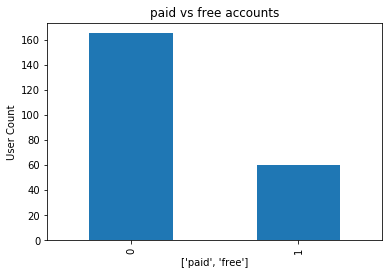

In [38]:
# visualize paid vs free accounts
df_level_pd = df.select('userId', 'user_paid').distinct().groupBy('user_paid').count().toPandas()

df_level_pd['count'].plot(kind='bar');
plt.title('paid vs free accounts')
plt.xlabel(['paid', 'free'])
plt.ylabel('User Count');

<b>Users by Gender

In [39]:
# distribution by gender
df.select('userId', 'gender').distinct().groupBy('gender').count()\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2)).show()

+------+-----+-------+
|gender|count|percent|
+------+-----+-------+
|     F|  104|   0.46|
|     M|  121|   0.54|
+------+-----+-------+



In [40]:
# distribution between male and female is quite normal with slightly more unique male users

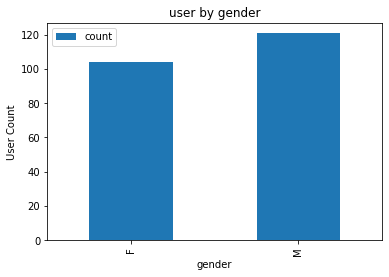

In [41]:
# plot gender distribution
df_gender_pd = df.select('userId', 'gender').distinct().groupBy('gender').count().toPandas()

df_gender_pd.plot(kind='bar',  x='gender', label=False)
plt.title('user by gender')
plt.ylabel('User Count');

In [42]:
# calculate churn based on gender
# first, get a list of user ids who churned
churned_users = df.select('userId').where(df.churn == 1)
churned_users = [row.userId for row in churned_users.collect()]

In [43]:
# filter out user ids that are not in churn list and group by churn and gender
df1 = df.select("userId", "gender", 'churn').filter(~df.userId.isin(churned_users)).distinct().groupBy(["churn", "gender"]).count().sort('churn')

In [44]:
# select churend users in a second df and group by churn and gender
df2 = df.select("userId", "gender", 'churn').where(df.churn == 1).groupBy(["churn", "gender"]).count().sort('churn')

In [45]:
# concatenate both results
df_gender_churn = df1.union(df2)
df_male_churn = df_gender_churn.where(df_gender_churn.gender == 'M')
df_female_churn = df_gender_churn.where(df_gender_churn.gender == 'F')

In [46]:
# add percent column
df_gender_churn = df_gender_churn\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2))

# male only chrun ratio
df_male_churn = df_male_churn\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2))

# female only churn ratio
df_female_churn = df_female_churn\
    .withColumn('percent', round(col('count') / sum('count')\
    .over(Window.partitionBy()), 2))

df_gender_churn.show()
df_male_churn.show()
df_female_churn.show()

+-----+------+-----+-------+
|churn|gender|count|percent|
+-----+------+-----+-------+
|    0|     M|   89|    0.4|
|    0|     F|   84|   0.37|
|    1|     F|   20|   0.09|
|    1|     M|   32|   0.14|
+-----+------+-----+-------+

+-----+------+-----+-------+
|churn|gender|count|percent|
+-----+------+-----+-------+
|    0|     M|   89|   0.74|
|    1|     M|   32|   0.26|
+-----+------+-----+-------+

+-----+------+-----+-------+
|churn|gender|count|percent|
+-----+------+-----+-------+
|    0|     F|   84|   0.81|
|    1|     F|   20|   0.19|
+-----+------+-----+-------+



In [47]:
# slightly higher churn rate for male (26%) than for female users (19%)

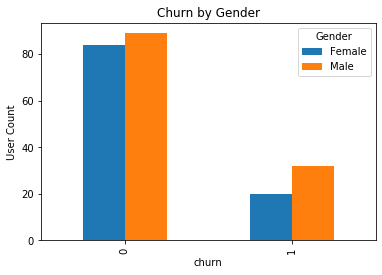

In [48]:
# visualize churn by gender
df_gender_churn_pd = df_gender_churn.toPandas()

df_gender_churn_pd[['churn', 'gender', 'count']].groupby(['churn', 'gender']).sum().unstack().plot(kind='bar')
plt.title('Churn by Gender')
plt.ylabel('User Count')
plt.legend(title='Gender', labels=['Female', 'Male'], loc='best');

In [49]:
# to make filtering on churned vs non churned / retained users easier, we add a column churn_user to the dateframe.
# this is based on the previous created list churned_users

label_churn_user = udf(lambda x: 1 if x in churned_users else 0, IntegerType())

df = df.withColumn('churn_user', label_churn_user('userId'))

In [50]:
# convert dataframe to pandas for visualization
df_pd = df.toPandas()

<b>Location

In [51]:
df_pd.drop_duplicates(subset=['userId']).groupby(['state', 'churn_user'])['userId'].count()\
    .unstack().fillna(0).sort_values(by=[1], ascending=False).head(10)

churn_user,0,1
state,,
CA,27.0,6.0
NY-NJ-PA,10.0,5.0
FL,11.0,3.0
MI,2.0,3.0
TX,13.0,3.0
KY,1.0,2.0
PA-NJ-DE-MD,3.0,2.0
AZ,5.0,2.0
CO,2.0,2.0


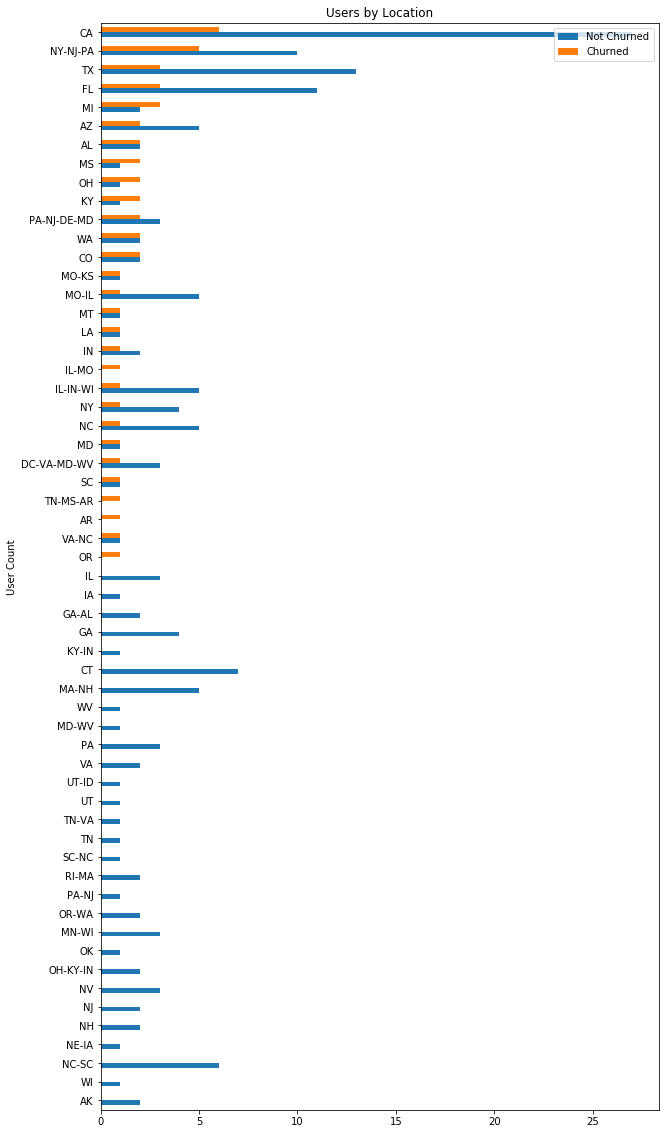

In [52]:
# df_pd_state
df_pd.drop_duplicates(subset=['userId']).groupby(['state', 'churn_user'])['userId'].count()\
    .unstack().fillna(0).sort_values(by=[1], ascending=True)\
    .plot(kind='barh', figsize=(10, 20));

plt.title('');
plt.ylabel('User Count');
plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');
plt.title('Users by Location');

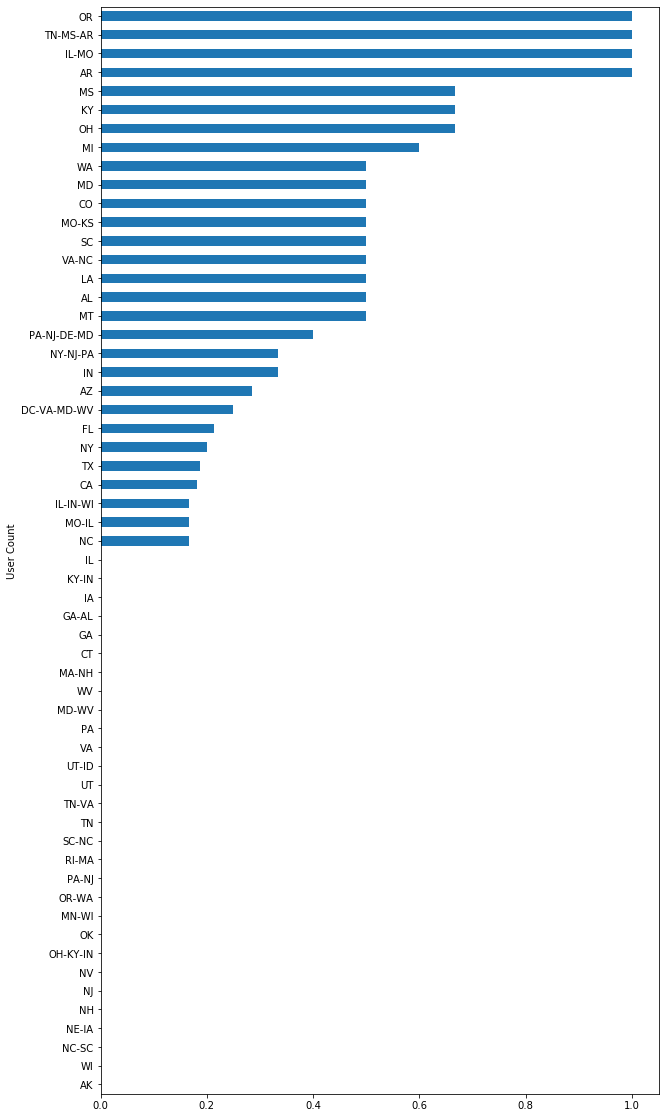

In [53]:
# df_pd_state
df_pd.drop_duplicates(subset=['userId']).groupby(['state'])['churn_user'].mean()\
    .fillna(0).sort_values(ascending=True)\
    .plot(kind='barh', figsize=(10, 20));

plt.title('');
plt.ylabel('User Count');
#plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');

In [54]:
# location

<b>Browser, System and Device</b>

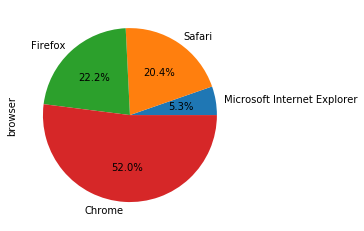

In [55]:
# 
df_pd.drop_duplicates(subset=['userId'])['browser'].value_counts().sort_values(ascending=True)\
    .plot(kind='pie', autopct='%1.1f%%', startangle=0);

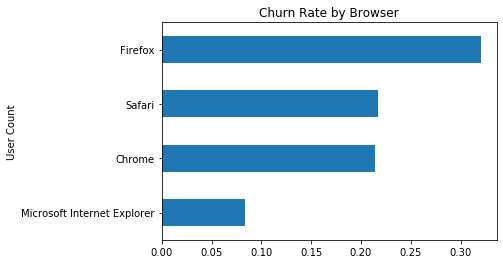

In [56]:
# churn by browser
df_pd.drop_duplicates(subset=['userId']).groupby(['browser'])['churn_user'].mean()\
    .fillna(0).sort_values(ascending=True)\
    .plot(kind='barh');

plt.title('Churn Rate by Browser');
plt.ylabel('User Count');
#plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');

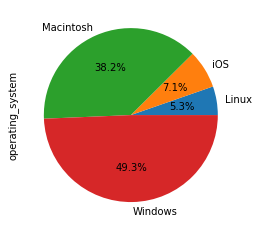

In [57]:
# operating system
df_pd.drop_duplicates(subset=['userId'])['operating_system'].value_counts().sort_values(ascending=True)\
    .plot(kind='pie', autopct='%1.1f%%');

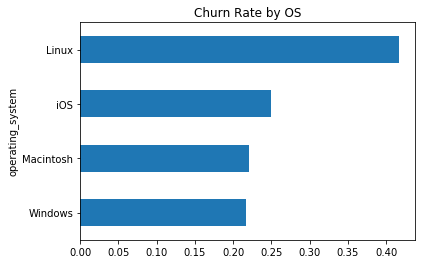

In [58]:
# churn by operating system
df_pd.drop_duplicates(subset=['userId']).groupby(['operating_system'])['churn_user'].mean()\
    .sort_values(ascending=True)\
    .plot(kind='barh');

plt.title('Churn Rate by OS');
#plt.ylabel('User Count');
#plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');

In [59]:
# churn by device

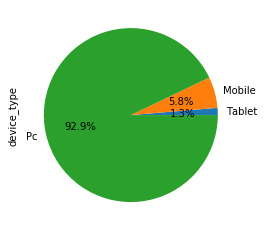

In [60]:
# device
df_pd.drop_duplicates(subset=['userId'])['device_type'].value_counts().sort_values(ascending=True)\
    .plot(kind='pie', autopct='%1.1f%%');

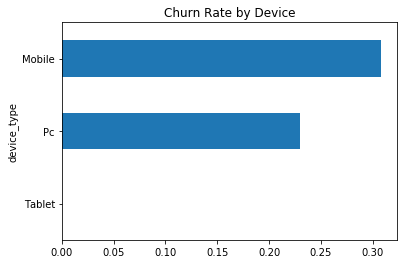

In [61]:
# churn by device
df_pd.drop_duplicates(subset=['userId']).groupby(['device_type'])['churn_user'].mean()\
    .sort_values(ascending=True)\
    .plot(kind='barh');

plt.title('Churn Rate by Device');
#plt.ylabel('User Count');
#plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');

In [62]:
df_pd.drop_duplicates(subset=['userId']).groupby('device_type').mean()

,itemInSession,length,registration,sessionId,status,ts,churn,user_paid,churn_user
device_type,,,,,,,,,
Mobile,0.000000,236.024582,1.535171e+12,89.615385,200.0,1.539158e+12,0.0,0.615385,0.307692
Pc,1.023923,246.377865,1.535588e+12,140.062201,200.0,1.538887e+12,0.0,0.736842,0.229665
Tablet,2.000000,283.898320,1.538403e+12,581.666667,200.0,1.539353e+12,0.0,1.000000,0.000000


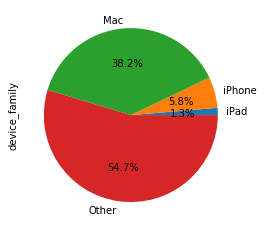

In [63]:
# device family
df_pd.drop_duplicates(subset=['userId'])['device_family'].value_counts().sort_values(ascending=True)\
    .plot(kind='pie', autopct='%1.1f%%');

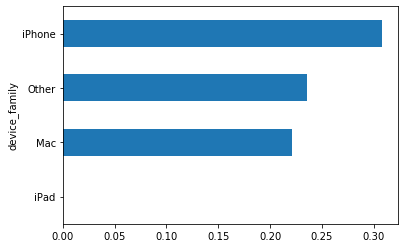

In [64]:
# churn by device family
df_pd.drop_duplicates(subset=['userId']).groupby(['device_family'])['churn_user'].mean()\
    .sort_values(ascending=True)\
    .plot(kind='barh');

plt.title('');
#plt.ylabel('User Count');
#plt.legend(title='', labels=['Not Churned', 'Churned'], loc='upper right');

In [65]:
df_pd.drop_duplicates(subset=['userId']).groupby('device_family').mean()

,itemInSession,length,registration,sessionId,status,ts,churn,user_paid,churn_user
device_family,,,,,,,,,
Mac,0.255814,233.242714,1.535519e+12,105.372093,200.0,1.538884e+12,0.0,0.697674,0.220930
Other,1.560976,259.513016,1.535636e+12,164.317073,200.0,1.538889e+12,0.0,0.764228,0.235772
iPad,2.000000,283.898320,1.538403e+12,581.666667,200.0,1.539353e+12,0.0,1.000000,0.000000
iPhone,0.000000,236.024582,1.535171e+12,89.615385,200.0,1.539158e+12,0.0,0.615385,0.307692


<b>Artist

c:\python37-32\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\python37-32\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


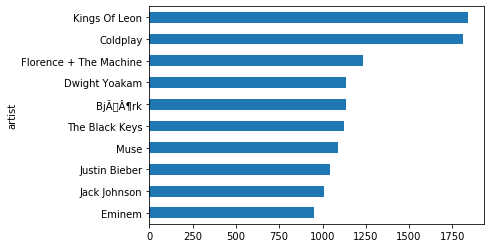

In [66]:
# top 10 artists by
df_pd.groupby('artist')['artist'].count().sort_values(ascending=True).tail(10).plot(kind='barh');

<b> Distibution of Data

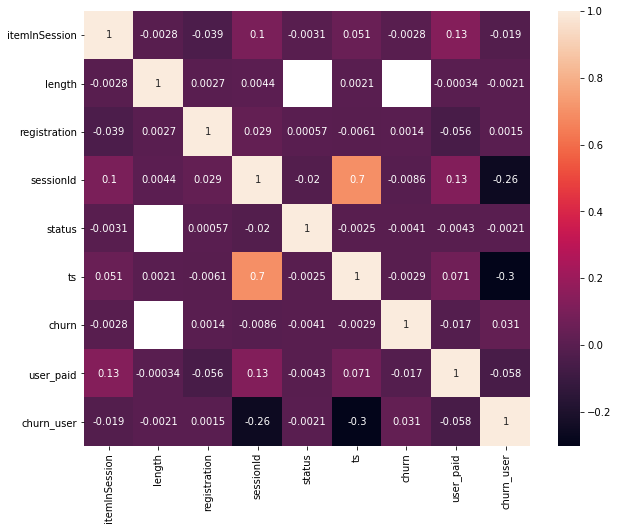

In [67]:
# correlation matrix for numeric columns
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_pd.corr(), annot=True, ax=ax)
plt.show()

In [68]:
# divide data set into churned users and users who did not churn
df_pd_churned = df_pd[df_pd.churn_user == 1]
df_pd_notchurned = df_pd[df_pd.churn_user == 0]

In [69]:
# imbalance in data
print(df_pd_churned.shape)
print(df_pd_notchurned.shape)

(44864, 30)
(233290, 30)


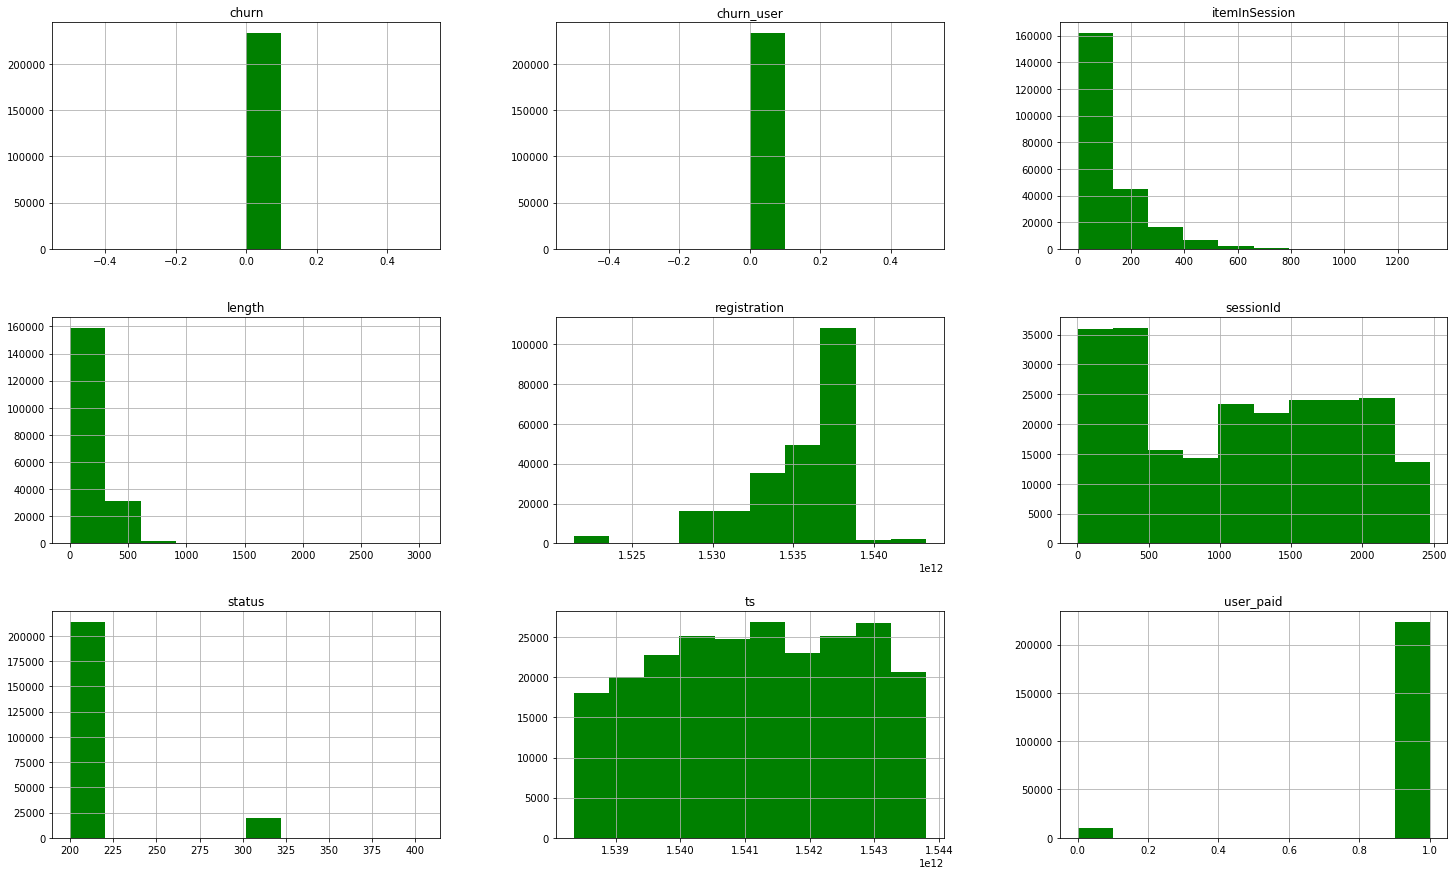

In [70]:
# use the histogram visualization to get some insights
df_pd_notchurned.hist(figsize=(25, 15), color='green');

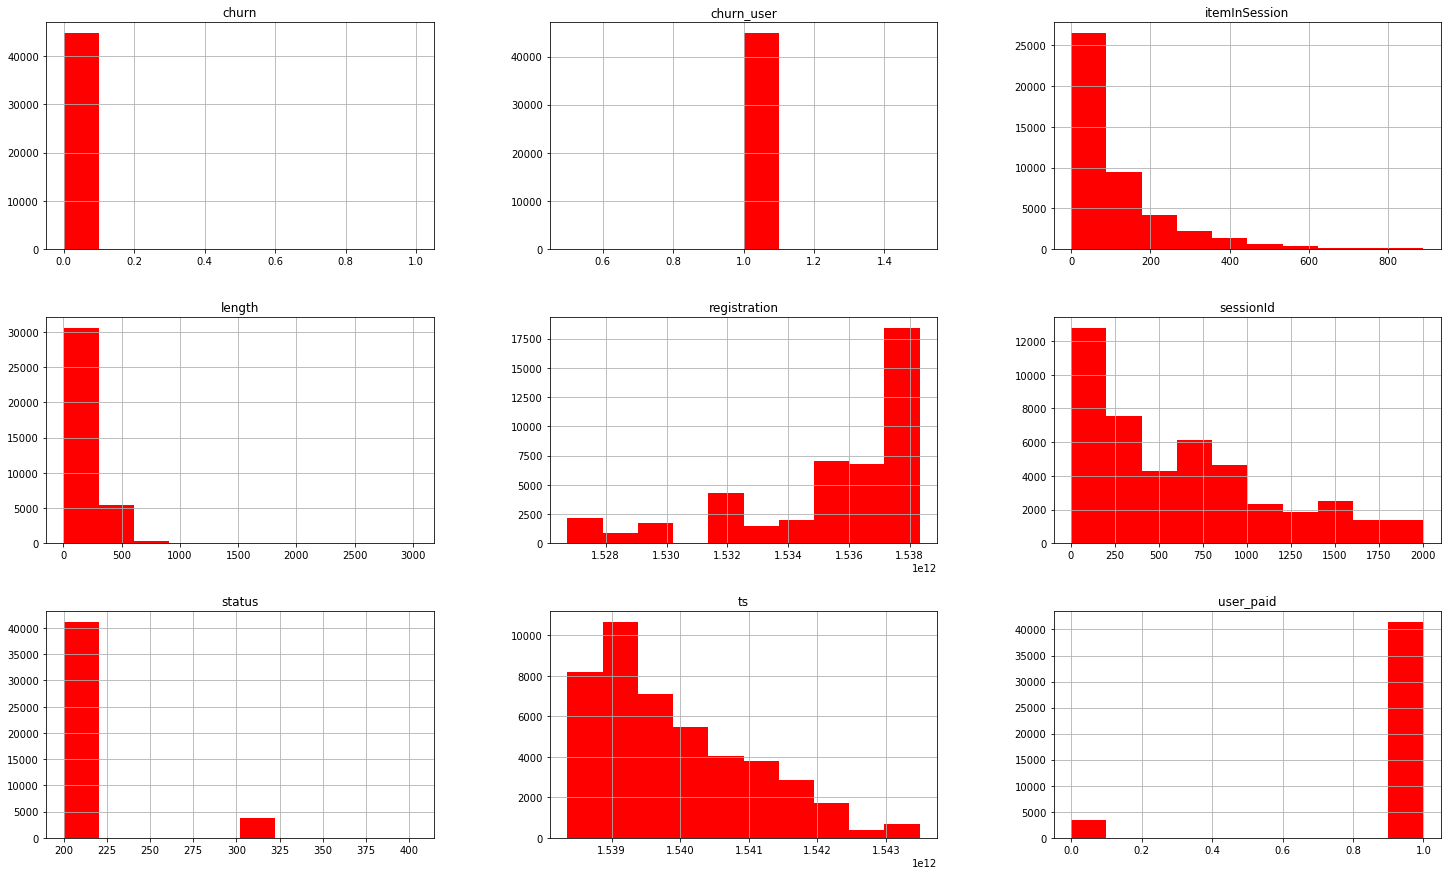

In [71]:
df_pd_churned.hist(figsize=(25, 15), color='red');

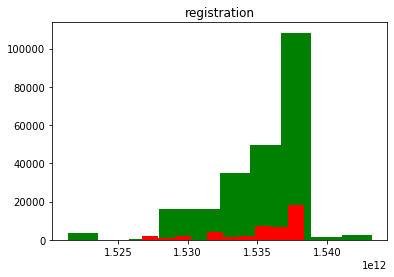

In [72]:
plt.title('registration')
plt.hist(df_pd_notchurned.registration, color='green', bins=10);
plt.hist(df_pd_churned.registration, color='red', bins=10);

In [73]:
# far more events from unchurned users than from churned users -> concentrate on relative values

<b>Page Visits

In [74]:
df_pd_churned.groupby('page').count().head() #.sort_values(ascending=True).plot(kind='barh')

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,city,state,browser,operating_system,device_type,device_family,device_model,churn,user_paid,churn_user
page,,,,,,,,,,,,,,,,,,,,,
About,0,56,56,56,56,56,0,56,56,56,...,56,56,56,56,56,56,23,56,56,56
Add Friend,0,636,636,636,636,636,0,636,636,636,...,636,636,636,636,636,636,251,636,636,636
Add to Playlist,0,1038,1038,1038,1038,1038,0,1038,1038,1038,...,1038,1038,1038,1038,1038,1038,417,1038,1038,1038
Cancel,0,52,52,52,52,52,0,52,52,52,...,52,52,52,52,52,52,23,52,52,52
Cancellation Confirmation,0,52,52,52,52,52,0,52,52,52,...,52,52,52,52,52,52,23,52,52,52


In [75]:
df_pd_churned.groupby('page').agg({'churn_user':'count'}).sort_values(by=['churn_user'], ascending=True)
# df_pd_churned.groupby('page').agg({'churn_user':'count'}).sort_values(by=['churn_user'], ascending=True)

,churn_user
page,
Submit Downgrade,9
Submit Upgrade,32
Error,32
Cancel,52
Cancellation Confirmation,52
About,56
Save Settings,58
Upgrade,112
Help,239


In [76]:
# all page visits
df_page_churned = df_pd_churned.groupby('page').agg({'churn_user':'count'})
df_page_notchurned = df_pd_notchurned.groupby('page').agg({'churn_user':'count'})
df_page_all = pd.merge(df_page_churned, df_page_notchurned, on='page', suffixes=('_1', '_0'))
df_page_all['churn_1%'] = (df_page_all.churn_user_1 / df_page_all.churn_user_1.sum())
df_page_all['churn_0%'] = (df_page_all.churn_user_0 / df_page_all.churn_user_0.sum())
df_page_all['%_diff'] = abs(df_page_all['churn_1%'] - df_page_all['churn_0%'])
df_page_all.sort_values(by=['churn_1%'], inplace=True)
# check sums

In [77]:
df_page_all.sort_values(by=['%_diff'], ascending=False)

,churn_user_1,churn_user_0,churn_1%,churn_0%,%_diff
page,,,,,
Roll Advert,967,2966,0.021604,0.012714,0.008890
NextSong,36394,191714,0.813092,0.821784,0.008692
Thumbs Up,1859,10692,0.041533,0.045831,0.004299
Thumbs Down,496,2050,0.011081,0.008787,0.002294
Add Friend,636,3641,0.014209,0.015607,0.001398
Home,1672,8410,0.037355,0.036050,0.001305
Logout,553,2673,0.012355,0.011458,0.000897
Upgrade,112,387,0.002502,0.001659,0.000843
Settings,270,1244,0.006032,0.005332,0.000700


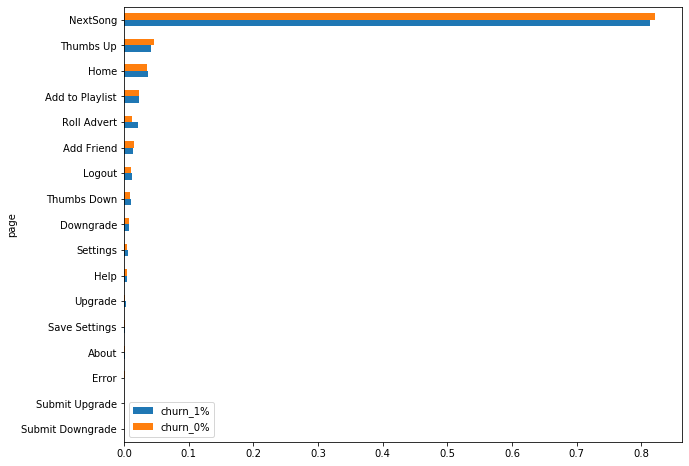

In [78]:
df_page_all[['churn_1%', 'churn_0%']].plot(kind='barh', figsize=(10, 8));

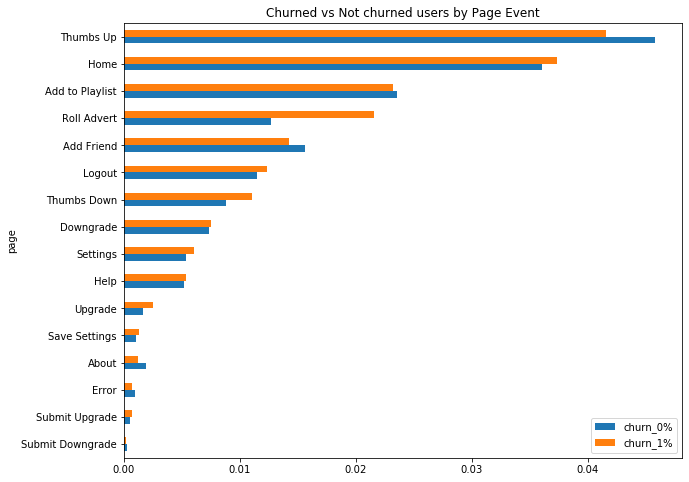

In [79]:
df_page_all[df_page_all.index != 'NextSong'][['churn_0%', 'churn_1%']]\
    .plot(kind='barh', 
          figsize=(10, 8));
plt.title('Churned vs Not churned users by Page Event');

<b>Paid vs Free accounts

In [80]:
pd.set_option('max_columns', None)
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,registration_time,event_timestamp,city,state,browser,operating_system,device_type,device_family,device_model,churn,user_paid,churn_user
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-29 00:22:42,2018-10-01 02:01:57,Bakersfield,CA,Firefox,Windows,Pc,Other,None,0,1,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-09-30 20:20:30,2018-10-01 02:03:00,Boston-Cambridge-Newton,MA-NH,Chrome,Windows,Pc,Other,None,0,1,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-29 00:22:42,2018-10-01 02:06:34,Bakersfield,CA,Firefox,Windows,Pc,Other,None,0,1,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-09-30 20:20:30,2018-10-01 02:06:56,Boston-Cambridge-Newton,MA-NH,Chrome,Windows,Pc,Other,None,0,1,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-09-29 00:22:42,2018-10-01 02:11:16,Bakersfield,CA,Firefox,Windows,Pc,Other,None,0,1,0


In [81]:
# update analysis paid vs free users
df_pd_level_0 = df_pd_notchurned.drop_duplicates(subset=['userId']).groupby(['churn_user', 'user_paid']).agg({'userId':'count'})
df_pd_level_1 = df_pd_churned.drop_duplicates(subset=['userId']).groupby(['churn_user', 'user_paid']).agg({'userId':'count'})
df_pd_level_0['%_1'] = df_pd_level_0.userId / df_pd_level_0.userId.sum()
df_pd_level_1['%_1'] = df_pd_level_1.userId / df_pd_level_1.userId.sum()
df_pd_level_all = df_pd_level_0.append(df_pd_level_1)


In [82]:
df_pd_level_all

userId       %_1
churn_user user_paid                  
0          0              44  0.254335
           1             129  0.745665
1          0              16  0.307692
           1              36  0.692308

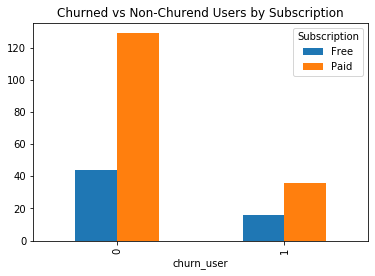

In [83]:
df_pd_level_all.unstack()[['userId']].plot(kind='bar');
plt.legend(title='Subscription', labels=['Free', 'Paid'], loc='best');
plt.title('Churned vs Non-Churend Users by Subscription');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [84]:
# Modelling and training is done at a later point.
# The goal of this project is to perform initial data analysis and to inform management
# for decision making. Based on discussion, it can be decided in which direction to proceed.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [85]:
# second parser 'user-agents' has been added to the load & cleaning section after having done initial analysis.